## FIFA PROJECT

In [282]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats


In [307]:

df=pd.read_csv('fifa21_male2.csv', low_memory=False)

In [308]:
df.columns

Index(['ID', 'Name', 'Age', 'OVA', 'Nationality', 'Club', 'BOV', 'BP',
       'Position', 'Player Photo',
       ...
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'Gender'],
      dtype='object', length=107)

In [ ]:
df.transpose()

In [309]:
df=df.drop(['Player Photo','Club Logo','Flag Photo'],axis=1) #We drop all columns that contain images

### Length, Weight and Count Columns

In [310]:
def to_cm(x): #Converts Feet and Inches to cm, only works if we remove the last "
    feet, inches = x.split("'")
    feet = int(feet)
    inches = int(inches.strip('"'))
    return 2.54*((feet * 12) + inches)

In [311]:
to_cm("6'0")

182.88

In [312]:
df['Height'] = df['Height'].str[:-1] # removed the last "

In [313]:
df['Height'] = df['Height'].apply(to_cm) #To have one standard unit in the column height, we convert the column to cm

In [314]:
df[['Height']] #new column Height

,Height
0,182.88
1,177.80
2,175.26
3,180.34
4,170.18
...,...
17120,198.12
17121,177.80
17122,175.26
17123,175.26


In [315]:
df['Weight'] = df['Weight'].str[:-3] # removed lbs

In [316]:
df[['Weight']] #new column Height

,Weight
0,181
1,143
2,161
3,165
4,150
...,...
17120,165
17121,170
17122,154
17123,148


### Date Columns

In [317]:
df['Joined'] = pd.to_datetime(df['Joined']) ## changed the Joined date to a stronger format
df['Joined'] = df['Joined'].dt.strftime('%Y-%m-%d')
df[['Joined']]

,Joined
0,2008-07-01
1,2014-07-19
2,2016-01-07
3,NaN
4,2018-07-16
...,...
17120,2020-09-29
17121,2020-08-20
17122,2020-08-20
17123,2020-09-30


In [318]:
df['Loan Date End'] = pd.to_datetime(df['Loan Date End']) ## changed the Joined date to a stronger format
df['Loan Date End'] = df['Loan Date End'].dt.strftime('%Y-%m-%d')
df[['Loan Date End']]

,Loan Date End
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
17120,2021-06-30
17121,NaN
17122,NaN
17123,NaN


### Money columns

In [319]:
def multiply_column(df, col_name):
    df[col_name] = df[col_name].str.replace('€', '').astype(str)
    return df[col_name].apply(lambda x: float(x[:-1]) * 1000 if x.endswith('K') else float(x[:-1]) * 1000000 if x.endswith('M') else float(x))

In [320]:
df['Value'] = multiply_column(df, 'Value')

In [321]:
df[['Value']]

,Value
0,625000.0
1,600000.0
2,1100000.0
3,0.0
4,5500000.0
...,...
17120,550000.0
17121,130000.0
17122,130000.0
17123,475000.0


In [322]:
df['Wage'] = multiply_column(df, 'Wage')

In [323]:
df[['Wage']]

,Wage
0,7000.0
1,7000.0
2,15000.0
3,0.0
4,12000.0
...,...
17120,2000.0
17121,3000.0
17122,2000.0
17123,3000.0


In [324]:
df['Release Clause'] = multiply_column(df, 'Release Clause')

In [325]:
df[['Release Clause']]

,Release Clause
0,0.0
1,1100000.0
2,0.0
3,0.0
4,7200000.0
...,...
17120,0.0
17121,273000.0
17122,273000.0
17123,784000.0


### Remove roge K in Hits

In [ ]:
df['Hits'] = multiply_column(df, 'Hits')
df['Hits']

### Separation of contract column

In [327]:
df['available'] = df['Contract'].apply(lambda x: 1 if 'free' in x.lower() else 0)
df['start_year'] = df['Contract'].str.split(' ~ ').str[0].str.extract('(\d+)', expand=False).astype(float)
df['end_year'] = df['Contract'].str.split(' ~ ').str[1].str.extract('(\d+)', expand=False).astype(float)
df.loc[df['available'] == 1, ['start_year', 'end_year']] = None

In [328]:
df[['available']]

,available
0,0
1,0
2,0
3,0
4,0
...,...
17120,0
17121,0
17122,0
17123,0


In [329]:
df[['start_year']]

,start_year
0,2008.0
1,2014.0
2,2016.0
3,2009.0
4,2018.0
...,...
17120,30.0
17121,2020.0
17122,2020.0
17123,2020.0


In [330]:
df[['end_year']]

,end_year
0,2016.0
1,2019.0
2,2020.0
3,NaN
4,2021.0
...,...
17120,NaN
17121,2021.0
17122,2022.0
17123,2023.0


In [331]:
df['start_year'].isnull().sum()

339

In [332]:
df['end_year'].isnull().sum()

1300

In [333]:
df['available'].isnull().sum()

0

In [334]:
df['Contract'].str.lower().str.contains('free').sum()

339

In [335]:
df['available'].sum()

339

#### Separation of position column

In [336]:
# Split the Position column by whitespace
position_split = df['Position'].str.split(expand=True)

# Rename the columns
position_split.columns = [f"position_{i+1}" for i in range(position_split.shape[1])]

# Concatenate the split columns with the original dataframe
df = pd.concat([df, position_split], axis=1)

### Remove stars

In [337]:
df['W/F'] = df['W/F'].str.replace('★', '')

In [338]:
df[['W/F']]

,W/F
0,3
1,4
2,4
3,3
4,4
...,...
17120,2
17121,3
17122,3
17123,4


In [339]:
df['SM'] = df['SM'].str.replace('★', '')

In [340]:
df[['SM']]

,SM
0,2
1,3
2,4
3,1
4,4
...,...
17120,2
17121,2
17122,2
17123,2


In [341]:
df['IR'] = df['IR'].str.replace('★', '')

In [342]:
df[['IR']]

,IR
0,2
1,1
2,2
3,1
4,4
...,...
17120,1
17121,1
17122,1
17123,1


### Slpit attribute columns into base and bonus columns

In [343]:
def split_columns(df, col_name):
    if col_name+'_base' in df.columns and col_name+'_bonus' in df.columns:
        print(f'Columns {col_name}_base and {col_name}_bonus already exist.')
        return df
    new_cols = df[col_name].str.split('+', expand=True)
    new_cols = new_cols.rename(columns={0: col_name+'_base', 1: col_name+'_bonus'})
    df = pd.concat([df, new_cols], axis=1)
    return df

In [344]:
df = split_columns(df, 'LS')
df = split_columns(df, 'ST')
df = split_columns(df, 'RS')
df = split_columns(df, 'LW')
df = split_columns(df, 'LF')
df = split_columns(df, 'CF')
df = split_columns(df, 'RF')
df = split_columns(df, 'RW')
df = split_columns(df, 'LAM')
df = split_columns(df, 'CAM')
df = split_columns(df, 'RAM')
df = split_columns(df, 'LM')
df = split_columns(df, 'LCM')
df = split_columns(df, 'CM')
df = split_columns(df, 'RCM')
df = split_columns(df, 'RM')
df = split_columns(df, 'LWB')
df = split_columns(df, 'LDM')
df = split_columns(df, 'CDM')
df = split_columns(df, 'RDM')
df = split_columns(df, 'RWB')
df = split_columns(df, 'LB')
df = split_columns(df, 'LCB')
df = split_columns(df, 'CB')
df = split_columns(df, 'RCB')
df = split_columns(df, 'RB')
df = split_columns(df, 'GK')

In [345]:
df = df.drop(['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'Contract'], axis=1)


In [415]:
df.to_csv('fifa_male_excel_clean_v1.csv', index=False)


## Load the data from the first round of cleaning

In [423]:
df=pd.read_csv('fifa_male_excel_clean_v1.csv', low_memory=False)

In [424]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
null_counts = df.isnull().sum()
print(null_counts)

ID                      0
Name                    0
Age                     0
OVA                     0
Nationality             0
Club                   18
BOV                     0
BP                      0
Position                0
POT                     0
Team & Contract         0
Height                  0
Weight                  0
foot                    0
Growth                  0
Joined                  0
Value                   0
Wage                    0
Release Clause          0
Attacking               0
Crossing                0
Finishing               0
Heading Accuracy        0
Short Passing           0
Volleys                 0
Skill                   0
Dribbling               0
Curve                   0
FK Accuracy             0
Long Passing            0
Ball Control            0
Movement                0
Acceleration            0
Sprint Speed            0
Agility                 0
Reactions               0
Balance                 0
Power                   0
Shot Power  

In [425]:
subset = df.loc[:, ['Club', 'Position', 'Joined', 'Volleys', 'Curve', 'Agility', 'Balance', 'Jumping', 'Interceptions', 'Positioning', 'Vision', 'Composure', 'Sliding Tackle', 'A/W', 'D/W']]
subset_null = subset.isnull()

#### Testing if the 58 Nulls correspond to the same rows:

In [426]:
joined_null = df['Joined'].isnull()
volleys_null = df['Volleys'].isnull()
curve_null = df['Curve'].isnull()
agility_null = df['Agility'].isnull()
balance_null = df['Balance'].isnull()
jumping_null = df['Jumping'].isnull()
vision_null = df['Vision'].isnull()
sliding_tackle_null = df['Sliding Tackle'].isnull()

# combine into a single array
combined_null = np.array([joined_null, volleys_null, curve_null, agility_null, balance_null, jumping_null, vision_null, sliding_tackle_null])

#Check if the 58 rows all have nulls in the same places 
print(np.all(combined_null, axis=0).sum())


0


#### Remove the 58 rows that contain simultaneous nulls in the columns listed above

In [427]:
df.dropna(subset=['Joined', 'Volleys', 'Curve', 'Agility', 'Balance', 'Jumping', 'Vision', 'Sliding Tackle'], inplace=True)

In [428]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
null_counts = df.isnull().sum()
null_percentages = null_counts/df.isnull().count()
null_percentages = null_percentages[null_percentages > 0.01]
print(null_percentages)

Composure     0.021386
start_year    0.019453
end_year      0.072772
position_2    0.511865
position_3    0.860315
position_4    0.998594
dtype: float64


#### The loan end date column has over 94% of Null values, we will drop that column

In [ ]:
df = df.drop('Loan Date End', axis=1)

In [430]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
null_counts = df.isnull().sum()
null_percentages = null_counts/df.isnull().count()
null_percentages = null_percentages[null_percentages > 0.01]
print(null_percentages)

Composure     0.021386
start_year    0.019453
end_year      0.072772
position_2    0.511865
position_3    0.860315
position_4    0.998594
dtype: float64


#### Fill missing Possition1 with correspondong best possition BP

In [391]:
df['Position'] = df['Position'].fillna(df['BP'])
df['position_1'] = df['position_1'].fillna(df['BP'])

### Make numerical encoders for categorical variables

In [431]:
categoricals=df.select_dtypes(include=[object])
for col in categoricals.columns:
    print(col)

Name
Nationality
Club
BP
Position
Team & Contract
foot
Joined
A/W
D/W
Gender
position_1
position_2
position_3
position_4


In [433]:
### We will leave out Name, Nationality, Club , Team & Contract, Joined, Gender, position1 and positions 2-4

In [355]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
encoder = LabelEncoder()



In [ ]:
# Fit the encoder to the Position column
encoder.fit(df['position_1'])

# Transform the Position column using the fitted encoder
df['Position_code'] = encoder.transform(df['position_1'])

In [376]:
# Fit the encoder to the Best Position column
encoder.fit(df['BP'])

# Transform the Best Position column using the fitted encoder
df['BP_code'] = encoder.transform(df['BP'])

In [381]:
# Fit the encoder to the foot column
encoder.fit(df['foot'])

# Transform the Best foot column using the fitted encoder
df['foot_code'] = encoder.transform(df['foot'])

In [382]:
# Fit the encoder to the A/W attack work rate column
encoder.fit(df['A/W'])

# Transform the A/W attack work rate column using the fitted encoder
df['A/W_code'] = encoder.transform(df['A/W'])

In [383]:
# Fit the encoder to the D/W defensive work rate column
encoder.fit(df['D/W'])

# Transform the D/W defensive work rate column using the fitted encoder
df['D/W_code'] = encoder.transform(df['D/W'])

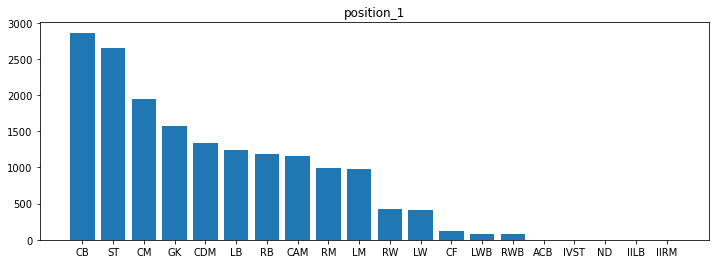

In [435]:
for c in ['position_1']:
    
    plt.figure(figsize=(12,4))
    x = df[c].value_counts().index.astype(str)  # use the index of value_counts as x
    plt.bar(x, df[c].value_counts())
    plt.title(c)
    plt.show()


In [436]:
df['position_1'].unique()

array(['LM', 'CM', 'CAM', 'RW', 'RB', 'CDM', 'ST', 'CB', 'GK', 'RM', 'CF',
       'LB', 'LWB', 'LW', 'RWB', 'ACB', 'IVST', 'ND', 'IILB', 'IIRM'],
      dtype=object)

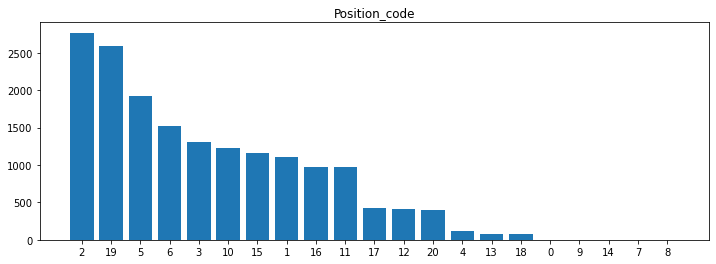

In [437]:

for c in ['Position_code']:
    
    plt.figure(figsize=(12,4))
    x = df[c].value_counts().index.astype(str)  # use the index of value_counts as x
    plt.bar(x, df[c].value_counts())
    plt.title(c)
    plt.show()

In [438]:
numerical=df.select_dtypes(include=[np.number])

In [440]:
for col in numerical.columns:
    print(col)

ID
Age
OVA
BOV
POT
Height
Weight
Growth
Value
Wage
Release Clause
Attacking
Crossing
Finishing
Heading Accuracy
Short Passing
Volleys
Skill
Dribbling
Curve
FK Accuracy
Long Passing
Ball Control
Movement
Acceleration
Sprint Speed
Agility
Reactions
Balance
Power
Shot Power
Jumping
Stamina
Strength
Long Shots
Mentality
Aggression
Interceptions
Positioning
Vision
Penalties
Composure
Defending
Marking
Standing Tackle
Sliding Tackle
Goalkeeping
GK Diving
GK Handling
GK Kicking
GK Positioning
GK Reflexes
Total Stats
Base Stats
W/F
SM
IR
PAC
SHO
PAS
DRI
DEF
PHY
Hits
available
start_year
end_year
LS_base
LS_bonus
ST_base
ST_bonus
RS_base
RS_bonus
LW_base
LW_bonus
LF_base
LF_bonus
CF_base
CF_bonus
RF_base
RF_bonus
RW_base
RW_bonus
LAM_base
LAM_bonus
CAM_base
CAM_bonus
RAM_base
RAM_bonus
LM_base
LM_bonus
LCM_base
LCM_bonus
CM_base
CM_bonus
RCM_base
RCM_bonus
RM_base
RM_bonus
LWB_base
LWB_bonus
LDM_base
LDM_bonus
CDM_base
CDM_bonus
RDM_base
RDM_bonus
RWB_base
RWB_bonus
LB_base
LB_bonus
LCB_base
LC

In [ ]:
numerical.isnull().sum()

In [453]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y), removing position code and position as well as data which has null entries and is not relevant
X = numerical.drop(['BP_code', 'Position_code','Composure','start_year', 'end_year'], axis=1)
y = numerical['BP_code']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Print the coefficients
print(model.coef_)

print(model.score(X_test, y_test))


[-4.88689138e-07  2.58180658e-02  3.19611008e-01 -6.34554797e-01
  1.57095578e-01 -2.78948925e-02  1.26229669e-03 -1.62515442e-01
 -6.49703753e-08  9.78861252e-06  1.34852662e-08  1.31243056e-02
  4.11875804e-02 -3.30866802e-02  5.24154305e-02 -2.22229233e-02
 -2.51691018e-02 -1.57087560e-02  3.23786633e-02  3.52354059e-02
 -1.77669127e-02 -7.54966221e-02  9.94070966e-03 -8.39841405e-03
 -1.33180187e-02 -8.98629927e-03  1.98463237e-02 -8.38263926e-03
  2.44221952e-03 -2.89175447e-03 -2.30520541e-03  1.18747268e-02
 -2.81210754e-03 -1.93172299e-03 -7.71744533e-03  1.06483100e-02
  3.71295664e-04 -4.25822370e-02  5.11412540e-02 -7.94481553e-03
  9.66281285e-03 -2.38274229e-02  8.48946876e-03 -2.62462612e-02
 -6.07063041e-03  1.87029743e-02  1.08084422e-02 -2.13073462e-04
  1.53220486e-02  4.73269266e-03 -1.19471357e-02 -8.35075744e-03
  1.60031724e-02 -4.47915507e-02 -5.92801062e-01  1.80046764e-01
  4.86975986e-02  7.58141614e-02 -1.35948660e-01  3.04305360e-02
 -9.83153646e-03  6.84107

In [447]:
# Compute the correlation coefficients between all numerical attributes and BP_code
correlations = numerical.corr()['BP_code'].drop(['BP_code', 'Position_code']).sort_values(ascending=False)

# Print the correlations in descending order
print(correlations)

Finishing           0.377400
PAC                 0.353461
Positioning         0.334203
SHO                 0.331839
Sprint Speed        0.313459
Acceleration        0.294859
Volleys             0.287013
Penalties           0.267938
ST_base             0.266198
RS_base             0.266198
LS_base             0.266198
Movement            0.243013
CF_base             0.224547
LF_base             0.224547
RF_base             0.224547
RW_base             0.216026
LW_base             0.216026
Agility             0.212707
Long Shots          0.206910
LCB_bonus           0.204149
CB_bonus            0.204149
RCB_bonus           0.204149
Attacking           0.200382
Dribbling           0.199636
Shot Power          0.195600
DRI                 0.191733
LM_base             0.167499
RM_base             0.167499
LAM_base            0.158550
CAM_base            0.158550
RAM_base            0.158550
Power               0.156750
SM                  0.143770
Curve               0.126130
Balance       

#### Attempted the same, but removing everything with less than 10% correlation, the result was worse

In [454]:
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target (y), removing position code and position as well as data which has null entries and is not relevant
X = numerical.drop(['BP_code', 'Position_code','Composure','start_year', 'end_year','Height','PAS','PHY','Short Passing','POT','BOV','GK_base','Goalkeeping','GK Reflexes','GK Positioning','GK Handling','Weight','GK Diving','GK Kicking','RM_bonus','LM_bonus','RW_bonus','LW_bonus','OVA','IR','Strength','Reactions','Growth','Release Clause','Age','Value','LCM_base','CM_base','RCM_base','Wage','LF_bonus','W/F', 'LCM_bonus', 'CM_bonus', 'RCM_bonus', 'foot_code', 'Stamina', 'D/W_code', 'Heading Accuracy', 'CAM_bonus', 'RAM_bonus', 'LAM_bonus', 'Skill', 'Vision', 'ID', 'Jumping', 'Total Stats', 'RB_bonus', 'LB_bonus', 'GK_bonus', 'Base Stats', 'FK Accuracy', 'end_year', 'RWB_bonus', 'LWB_bonus', 'Mentality', 'available', 'Hits', 'RF_bonus', 'CF_bonus'], axis=1)
y = numerical['BP_code']

# Create a LinearRegression model
model = LinearRegression()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Print the coefficients
print(model.coef_)

print(model.score(X_test, y_test))

[ 3.69615679e-02  1.14707597e-02 -6.00242794e-02 -6.01664446e-02
  8.22415124e-02 -2.00300234e-02 -9.98944734e-02  4.32009201e-02
 -2.92196689e-02 -3.21473887e-04  5.55362011e-03  4.98186649e-02
  2.21757509e-02  1.40592240e-02 -3.85555694e-02 -3.39873868e-02
  3.54223565e-02  1.63923589e-02  8.74602828e-02  6.43062400e-03
 -3.17044269e-03  1.41922728e-02 -1.83873461e-02  1.02463056e-03
 -9.30972157e-01  7.32929633e-02  8.36054941e-02 -3.45714091e-02
  2.22418929e-02  1.08914946e-01 -2.36259987e-01  1.08914946e-01
 -2.36259987e-01  1.08914946e-01 -2.36259987e-01 -1.15919118e-01
  1.90772734e-02  1.90772734e-02  1.90772734e-02 -1.15919118e-01
 -2.28716373e-01 -2.28716373e-01 -2.28716373e-01  2.80623352e-01
  2.80623352e-01  1.32620680e-02 -5.32654370e-02 -7.47354717e-02
 -5.32654370e-02 -7.47354717e-02 -5.32654370e-02 -7.47354717e-02
  1.32620680e-02  2.52022755e-02 -5.02953679e-02  2.54120418e-01
 -5.02953679e-02  2.54120418e-01 -5.02953679e-02  2.54120418e-01
  2.52022755e-02 -1.96591

In [ ]:
#### Attempted the same, but removing everything with less than 30% correlation, the result was worse

In [455]:
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target (y), removing position code and position as well as data which has null entries and is not relevant
X = numerical.drop(['BP_code', 'Position_code','Acceleration', 'Volleys', 'Penalties', 'ST_base', 'RS_base', 'LS_base', 'Movement', 'CF_base', 'LF_base', 'RF_base', 'RW_base', 'LW_base', 'Agility', 'Long Shots', 'LCB_bonus', 'CB_bonus', 'RCB_bonus', 'Attacking', 'Dribbling', 'Shot Power', 'DRI', 'LM_base', 'RM_base', 'LAM_base', 'CAM_base', 'RAM_base', 'Power', 'SM', 'Curve', 'Balance', 'Crossing', 'LDM_bonus', 'RDM_bonus', 'CDM_bonus', 'Ball Control', 'W/F', 'LCM_bonus', 'CM_bonus', 'RCM_bonus', 'foot_code', 'Stamina', 'D/W_code', 'Heading Accuracy', 'CAM_bonus', 'RAM_bonus', 'LAM_bonus', 'Skill', 'Vision', 'ID', 'Jumping', 'Total Stats', 'RB_bonus', 'LB_bonus', 'GK_bonus', 'Base Stats', 'FK Accuracy', 'end_year', 'RWB_bonus', 'LWB_bonus', 'Mentality', 'available', 'Hits', 'start_year', 'RF_bonus', 'CF_bonus', 'LF_bonus', 'Wage', 'RCM_base', 'CM_base', 'LCM_base', 'Value', 'Age', 'Composure', 'Release Clause', 'Growth', 'Reactions', 'Strength', 'IR', 'OVA', 'LW_bonus', 'RW_bonus', 'LM_bonus', 'RM_bonus', 'GK Kicking', 'GK Diving', 'Weight', 'GK Handling', 'GK Positioning', 'GK Reflexes', 'Goalkeeping', 'GK_base', 'BOV', 'POT', 'Short Passing', 'PHY', 'PAS', 'Height', 'Aggression', 'RWB_base', 'LWB_base', 'A/W_code', 'LB_base', 'RB_base', 'Long Passing', 'RS_bonus', 'LS_bonus', 'ST_bonus', 'CDM_base', 'RDM_base', 'LDM_base'], axis=1)
y = numerical['BP_code']

# Create a LinearRegression model
model = LinearRegression()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Print the coefficients
print(model.coef_)

print(model.score(X_test, y_test))

[ 0.04646853 -0.06460839 -0.10982508  0.09415176 -0.07739296 -0.02628064
 -0.07729634  0.02618401  0.14755974 -0.13085242  0.11003151  0.09769514
  0.09769514  0.09769514]
0.4150295019434358
